In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [82]:
# read 7-year-old data
data_path = './ncds_sweep0-3/tab/ncds0123.tab'
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')

In [83]:
# n415: 1M Epileptic condition
# 2: no
# 1, -1: defect data
# obtained at 1965, 7y

# n2032: 3M Epilepsy
# 1: no
# -1: defect data
# obtained at 1974, 16y

# focus on those not epileptic at 1965 but epileptic at 1969

In [84]:
mask_1M_no = data['n415'] == '2'

mask_3M_no = (data['n2032'] == '1')
mask_3M_defect = (data['n2032'] == '-1') | (data['n2032'] == ' ') | (data['n2032'] == '2')
mask_3M_yes = ~(mask_3M_no | mask_3M_defect)

mask_1M_no_3M_yes = mask_1M_no & mask_3M_yes

print '{} people have no epilepsy at 1965 (7-year-old)'.format(sum(mask_1M_no))
print '{} people have epilepsy at 1974 (16-year-old)'.format(sum(mask_3M_yes))
print '{} people have no epilepsy at 7-year-old but have epilepsy at 16-year-old'.format(\
    sum(mask_1M_no_3M_yes))
print '\nTheir id number:'
print data.index[mask_1M_no_3M_yes].values

13901 people have no epilepsy at 1965 (7-year-old)
60 people have epilepsy at 1974 (16-year-old)
32 people have no epilepsy at 7-year-old but have epilepsy at 16-year-old

Their id number:
['N10166J' 'N10171F' 'N10370L' 'N10597D' 'N10926A' 'N11763D' 'N11767H'
 'N12258V' 'N13349B' 'N14147X' 'N17236K' 'N17347R' 'N17839G' 'N18241L'
 'N18731Z' 'N19076V' 'N19158W' 'N20286W' 'N20371S' 'N20374V' 'N22184Z'
 'N22487M' 'N22895Z' 'N23481K' 'N24216Y' 'N24233Z' 'N24494U' 'N25162F'
 'N25418L' 'N25591Y' 'N26543U' 'N27163Q']


In [85]:
# predictor variables are those in 1, 2, 3 but no keyword 'epilep' in manual
# response variable is 'acquired epilepsy', all mask_1M_no, those in mask_3M_yes are 1, else 0

In [86]:
doi = data[mask_1M_no]
y_df = pd.Series( np.zeros(data.shape[0]) )
y_df[mask_1M_no_3M_yes.values] = 1
y_df = y_df[mask_1M_no.values]

mask_3M_defect = (doi['n2032'] == '-1') | (doi['n2032'] == ' ') | (doi['n2032'] == '2')
y_df = y_df[~mask_3M_defect.values]

print 'Epilepsy condition survey:'
print y_df.value_counts()

Epilepsy condition survey:
0.0    9382
1.0      32
dtype: int64


In [87]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep0-3/mrdoc/allissue/ncds0123_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# SPSS measurement level target string
target_string_1 = 'the SPSS measurement level is '

# locate SPSS measurement level
target_loc_1 = [m.end() for m in re.finditer(target_string_1, explain_text)]

# variable label target string
target_string_2 = 'Variable label = '

# locate variable label
target_loc_2 = [m.end() for m in re.finditer(target_string_2, explain_text)]

# remove the first one (id)
target_loc_2 = target_loc_2[1:]

# variable code target string
target_string_3 = 'Variable = '

# locate variable code
target_loc_3 = [m.end() for m in re.finditer(target_string_3, explain_text)]

# remove the first one (id)
target_loc_3 = target_loc_3[1:]

In [88]:
var_df = pd.DataFrame({}, columns = ['type', 'label'])

for i in range(len(target_loc_1)):
    # get variable code
    start_pt = target_loc_3[i]+15
    end_pt = explain_text.find('cf1', start_pt)-6
    var_code = explain_text[start_pt:end_pt]
    
    # get variable label
    start_pt = target_loc_2[i]+7
    end_pt = explain_text.find('\par', start_pt)
    var_label = explain_text[start_pt:end_pt]
    
    # get variable type
    char = explain_text[target_loc_1[i] + 9] 
    if char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in var_code:
        var_type = 'categorical'
    else:
        var_type = 'numerical'

    # append to DataFrame
    var_df.loc[var_code] = [var_type, var_label]

In [89]:
print '{} variables'.format(var_df.shape[0])
print 'sample variable list:'
var_df.head()

1764 variables
sample variable list:


,type,label
n622,categorical,0-3D Sex of child
n0region,categorical,Region at PMS (1958) - Birth
n1region,categorical,Region at NCDS1 (1965) - 7 years
n2region,categorical,Region at NCDS2 (1969) - 11 years
n3region,categorical,Region at NCDS3 (1974) - 16 years


In [90]:
variable_of_interest = []
for index, row in var_df.iterrows():
    starting_text = row['label'][0:1]
    if 'epilep' in row['label'] or 'Epilep' in row['label']:
        continue
    if 'convuls' in row['label'] or 'Convuls' in row['label']:
        continue
    if 'Special Education' in row['label']:
        continue
    if 'Region' in row['label']:
        continue
    if 'neuro' in row['label']:
        continue
    if 'Reason' in row['label'] or 'reason' in row['label']:
        continue
    if 'handicap' in row['label']:
        continue
    if 'psychi' in row['label']:
        continue
    if 'patient' in row['label']:
        continue
    if index == 'n1910':
        continue
    if index == 'n1964':
        continue
    if index == 'n2032':
        continue
    if index == 'n2416':
        continue
    if index == 'n2598':
        continue
    if index == 'n2603':
        continue
    if index == 'n2604':
        continue
    if index == 'n2605':
        continue
    if index == 'n2606':
        continue
    if index == 'n2607':
        continue
    if index == 'n2608':
        continue
    if index == 'n2663':
        continue
    if index == 'n2664':
        continue
    if index == 'n2665':
        continue
    if index == 'n2666':
        continue
    if index == 'n2667':
        continue
    if index == 'n622' or starting_text == '2' or starting_text == '3':
        variable_of_interest.append(index)

print '{} predictors in file'.format( var_df.shape[0] )
print '{} predictors of interest'.format( len(variable_of_interest) )

1764 predictors in file
1196 predictors of interest


In [91]:
x_df = doi[variable_of_interest]
x_df = x_df[~mask_3M_defect]

In [92]:
# iterate through all variables
# dummify categorical variables
# standardize numeric variables

x_df_extended_list = []

for col in x_df.columns:
    # if this column is categorical
    if var_df.loc[col, 'type'] == 'categorical':
        # copy current column
        curr_df = x_df[col].copy()
        # format all value to string
        curr_df = curr_df.astype(str)
        # set value ' ' to value '-1'
        curr_df[curr_df == ' '] = '-1'
        # if this column contains NaN
        if curr_df.isnull().values.any():
            # get dummy with NaN as a unique value
            dummy = pd.get_dummies(curr_df, dummy_na = True)
        # if this column does not contain NaN
        else:
            # get dummy without considering NaN
            dummy = pd.get_dummies(curr_df, dummy_na = False)
        # reset column label of dummy
        dummy.columns = [str(col)+'='+str(value) for value in dummy.columns]
        # reset index label of dummy
        dummy.index = x_df.index
        # append current dummy DataFrame to master list
        x_df_extended_list.append(dummy)
    # if this column is numerical
    else:
        # copy current column
        curr_df = x_df[col].copy()
        # set value ' ' to value -1
        curr_df[curr_df == ' '] = -1
        # set value NaN to value -1
        curr_df[curr_df.isnull()] = -1
        # convert current column to float
        curr_df = curr_df.astype(float)
        # standardize it
        curr_df = pd.DataFrame(scale(curr_df.values))
        # reset index label of current DataFrame
        curr_df.index = x_df.index
        # reset column name of current DataFrame
        curr_df.columns = [col]
        # append current DataFrame to master list
        x_df_extended_list.append(curr_df)
        
# concatenate master list to get master data
x_df_extended = pd.concat(x_df_extended_list, axis = 1)

print '{} observations'.format(x_df_extended.shape[0])
print '{} variables (after dummy expansion)'.format(x_df_extended.shape[1])

9414 observations
8724 variables (after dummy expansion)


In [93]:
def scorer(estimator, x, y):
    y_predict = estimator.predict(x)
    cm = confusion_matrix(y, y_predict)
    accuracy_all = estimator.score(x, y)
    accuracy_healthy = float(cm[0,0])/float(cm[0,0]+cm[0,1])
    accuracy_epilepsy = float(cm[1,1])/float(cm[1,0]+cm[1,1])
    return accuracy_epilepsy

In [94]:
weight_list = [{1:value} for value in 10**np.arange(0, 3, 1)]
penalty_list = ['l1', 'l2']
parameters = {'class_weight':weight_list, 'penalty':penalty_list}
gscv = GridSearchCV(LogisticRegression(C = 10**10, solver = 'liblinear'),\
                    parameters, scoring = 'roc_auc')

#weight_list = [{1:value} for value in 10**np.arange(0, 3, 1)]
#n_est = [5, 10, 50, 100, 500]
#n_depth = [1, 2, 3, 4, 5]
#parameters = {'n_estimators':n_est, 'max_depth':n_depth, 'class_weight':weight_list}
#gscv = GridSearchCV(RandomForestClassifier(), parameters, scoring = scorer)

gscv.fit(x_df_extended.values, y_df.values)
best_model = gscv.best_estimator_

In [103]:
best_model = gscv.best_estimator_

#best_model = KNeighborsClassifier(n_neighbors=5)
#best_model.fit(x_df_extended.values, y_df.values)

kf = KFold(n_splits = 3)
adf = pd.DataFrame({}, columns = ['accuracy_all', 'accuracy_healthy', 'accuracy_epilepsy'])
index = 0

for train_index, test_index in kf.split(x_df_extended.values):
    x_train = x_df_extended.values[train_index, :]
    x_test = x_df_extended.values[test_index, :]
    y_train = y_df.values[train_index]
    y_test = y_df.values[test_index]
    
    best_model.fit(x_train, y_train)
    
    #y_predict = best_model.predict(x_test)
    y_predict = best_model.predict_proba(x_test)[:, 0]
    mask = y_predict > (1-1e-6)
    y_predict[mask] = 0
    y_predict[~mask] = 1
    
    cm = confusion_matrix(y_test, y_predict)
    accuracy_all = best_model.score(x_test, y_test)
    accuracy_epilepsy = float(cm[1,1])/float(cm[1,0]+cm[1,1])
    accuracy_healthy = float(cm[0,0])/float(cm[0,0]+cm[0,1])
    
    adf.loc[index] = [accuracy_all, accuracy_healthy, accuracy_epilepsy]

In [104]:
print 'Best parameter:', gscv.best_params_
print 'Best precision score:', gscv.best_score_
print adf.mean()

Best parameter: {'penalty': 'l1', 'class_weight': {1: 10}}
Best precision score: 0.712997486855
accuracy_all         0.996495
accuracy_healthy     0.820275
accuracy_epilepsy    0.636364
dtype: float64


In [111]:
# get coefficient
best_model = gscv.best_estimator_
coef = best_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-21:][::-1]
most_neg_var_index = np.argsort(coef)[0:20]

print 'most positive variables'
for index in most_pos_var_index:
    print coef[index], x_df_extended.columns[index],
    
    # get variable name
    if '=' in x_df_extended.columns[index]:
        var_name = x_df_extended.columns[index].split('=', 1)[0]
    else:
        var_name = x_df_extended.columns[index]
    
    print var_df['label'].loc[var_name]

most positive variables
6.60958219898 n2452=15 3P Source of income past year-MC 1:10
5.72517959839 n1656=60 2M L ear-hearing loss at 500 CPS x 5dB
5.46419756416 n1966=0 3M Systemic examination-2nd condition
5.38970315046 n2762=7 3I N intended A-levels:Other subjects
4.68441930841 n1372=4 2P Age at which appendix removed
4.41440078655 n2239=25 3S 11th Subject studied
4.36321580996 n2373=3 3P Age child 1st cared for by mother sub
4.26057969524 n2364=6 3P Boys in hhld yngr than NCDS child
4.21927157586 n1715=5 3S N of subjects studied-Domestic
4.17176067142 n2594=9 3P Operations-hernia repair
4.12562693891 n1635=80 2M R ear-hearing loss at 250 CPS x 5dB
4.08656401598 n2367=7 3P Has NCDS child any older brothers
3.96599875728 n1372=6 2P Age at which appendix removed
3.9340394538 n2774=96 3I Expects 1st job-job description
3.92566140548 n2709=11 3I Date on Individual Qustionnaire-month
3.89773126081 n15=5 3W Warnock disabled school leaver study
3.87864987399 n2585=16 3P Age 3rd most recent 

In [98]:
doi_epil = x_df_extended[(y_df == 1).values]
doi_healthy = x_df_extended[(y_df == 0).values]

most positive variables
6.60958219898 n2452=15 3P Source of income past year-MC 1:10


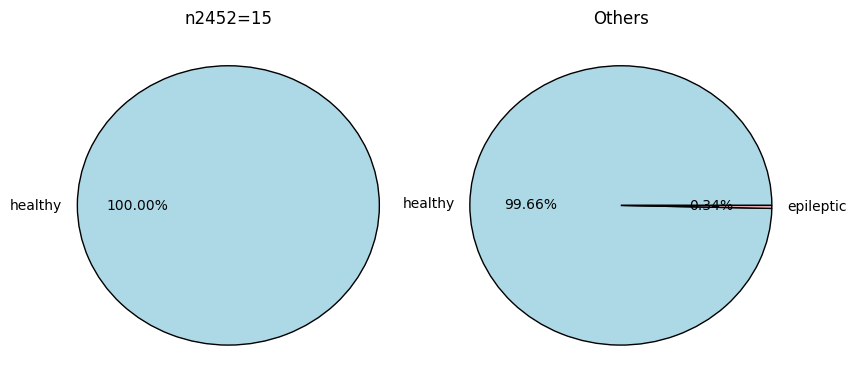

5.72517959839 n1656=60 2M L ear-hearing loss at 500 CPS x 5dB


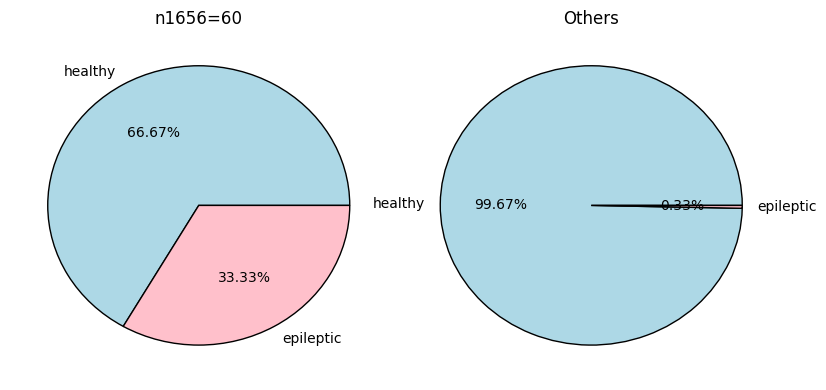

5.46419756416 n1966=0 3M Systemic examination-2nd condition


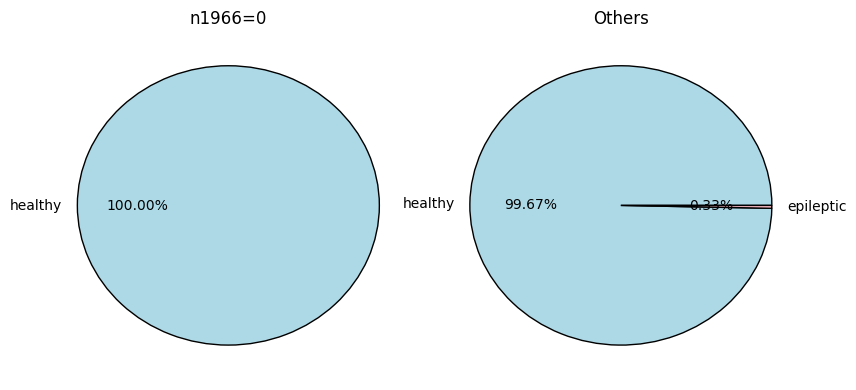

5.38970315046 n2762=7 3I N intended A-levels:Other subjects


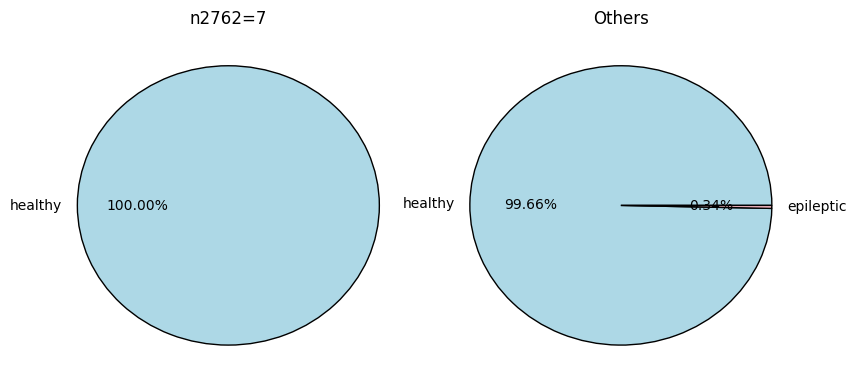

4.68441930841 n1372=4 2P Age at which appendix removed


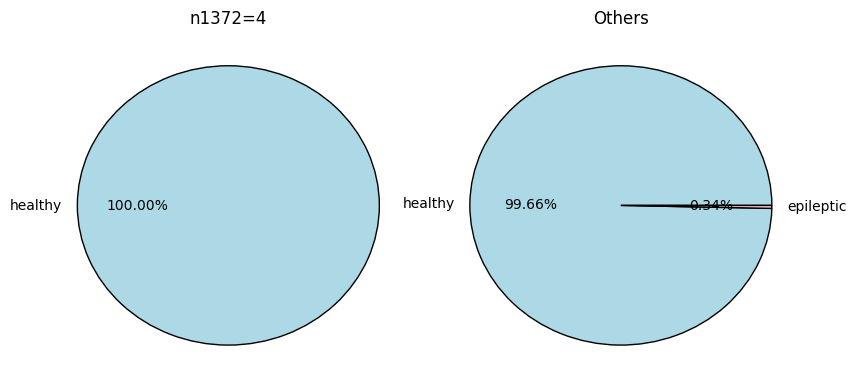

4.41440078655 n2239=25 3S 11th Subject studied


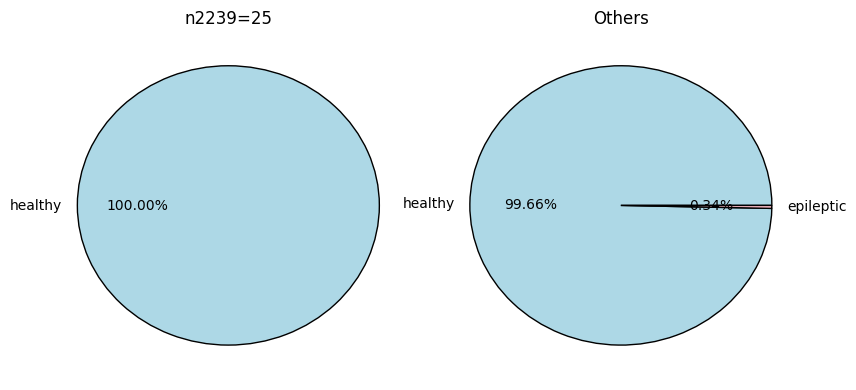

4.36321580996 n2373=3 3P Age child 1st cared for by mother sub


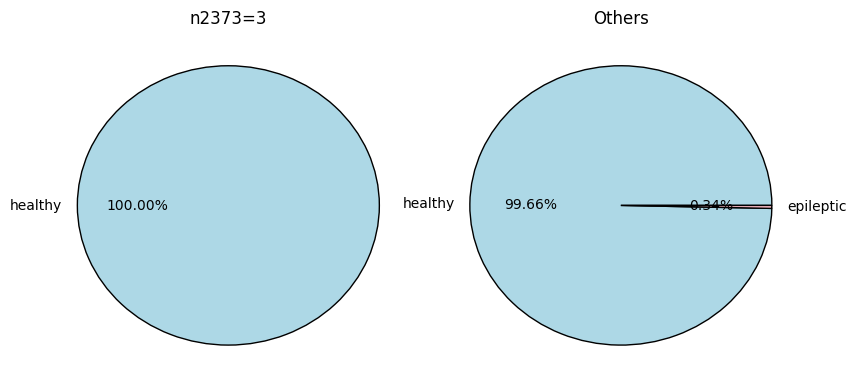

4.26057969524 n2364=6 3P Boys in hhld yngr than NCDS child


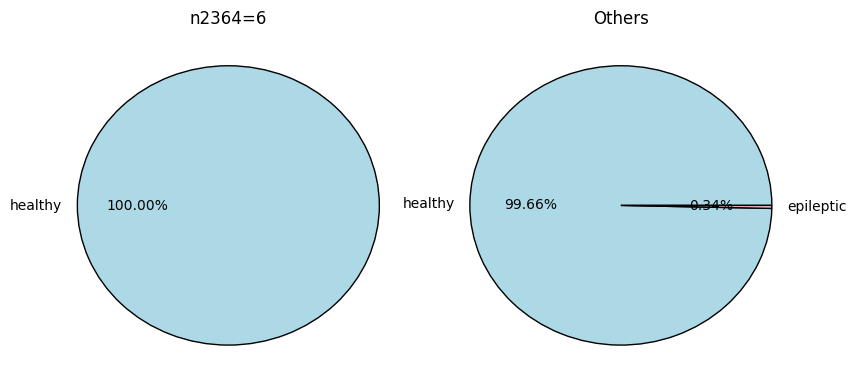

4.21927157586 n1715=5 3S N of subjects studied-Domestic


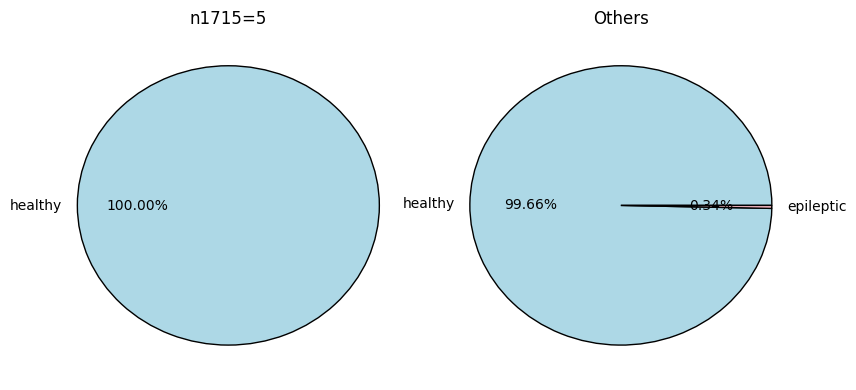

4.17176067142 n2594=9 3P Operations-hernia repair


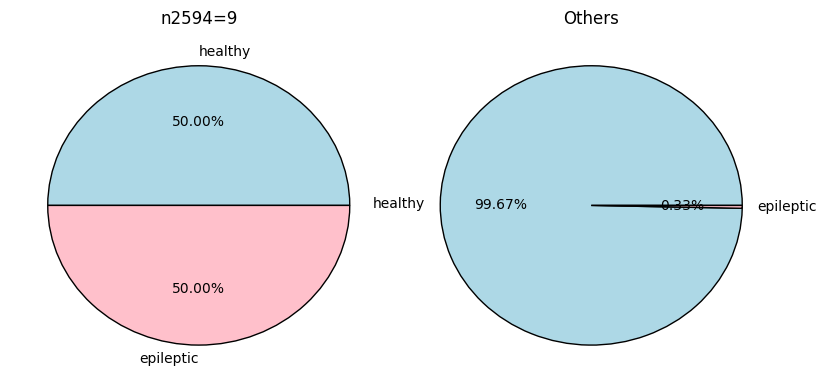

4.12562693891 n1635=80 2M R ear-hearing loss at 250 CPS x 5dB


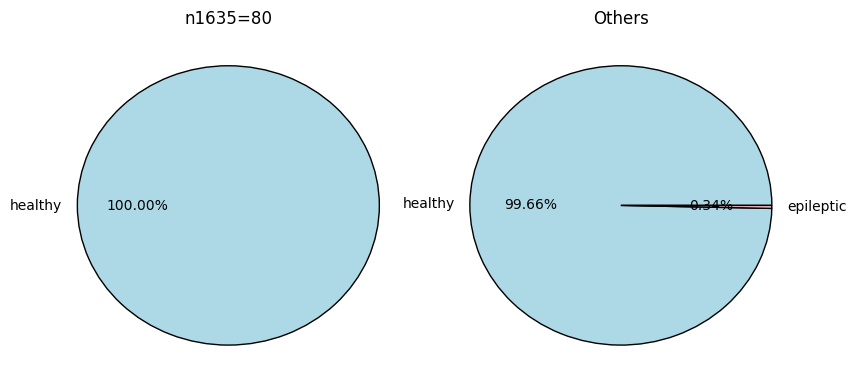

4.08656401598 n2367=7 3P Has NCDS child any older brothers


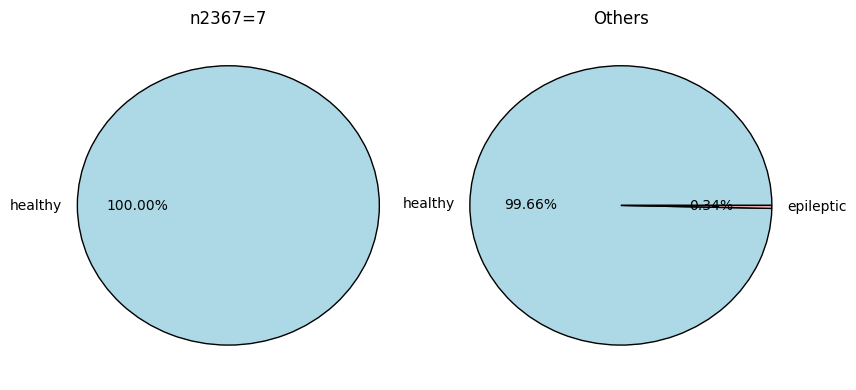

3.96599875728 n1372=6 2P Age at which appendix removed


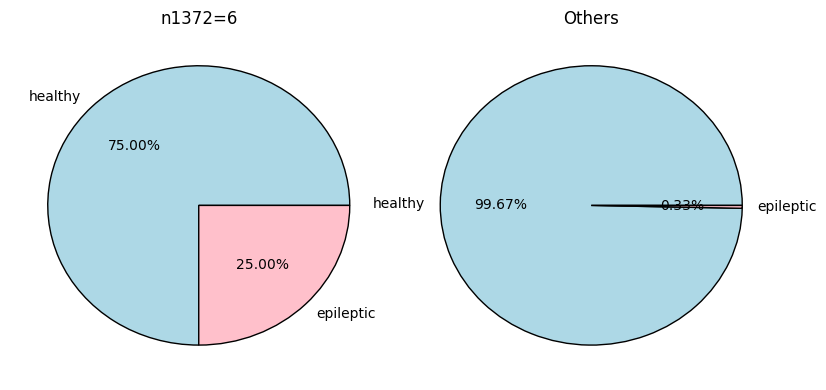

3.9340394538 n2774=96 3I Expects 1st job-job description


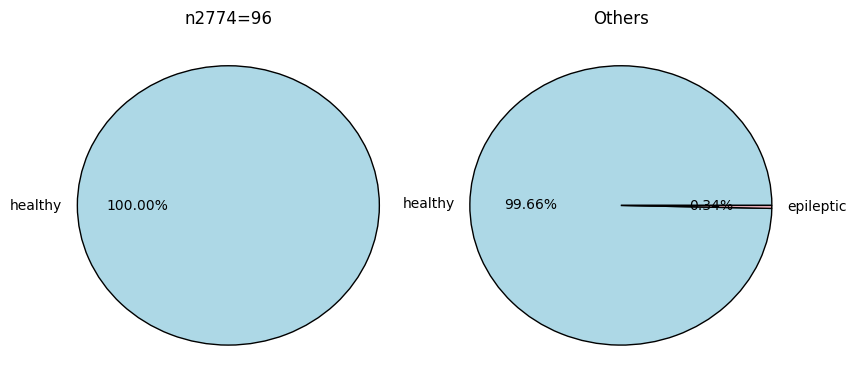

3.92566140548 n2709=11 3I Date on Individual Qustionnaire-month


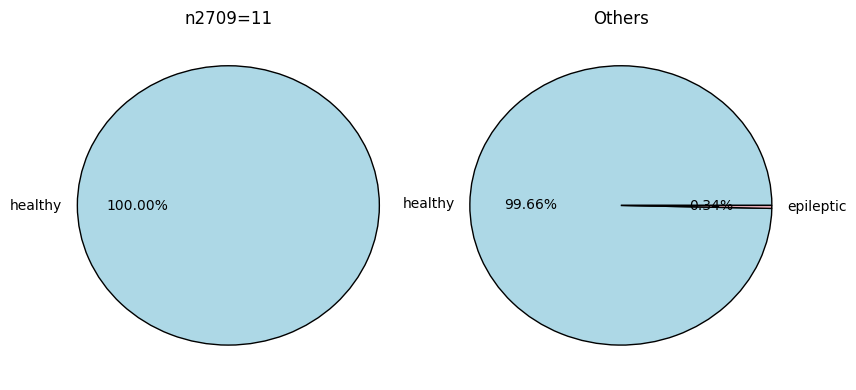

3.89773126081 n15=5 3W Warnock disabled school leaver study


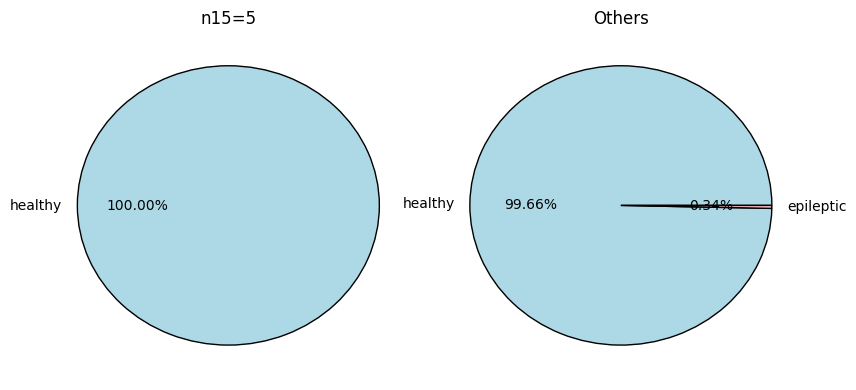

3.87864987399 n2585=16 3P Age 3rd most recent accident


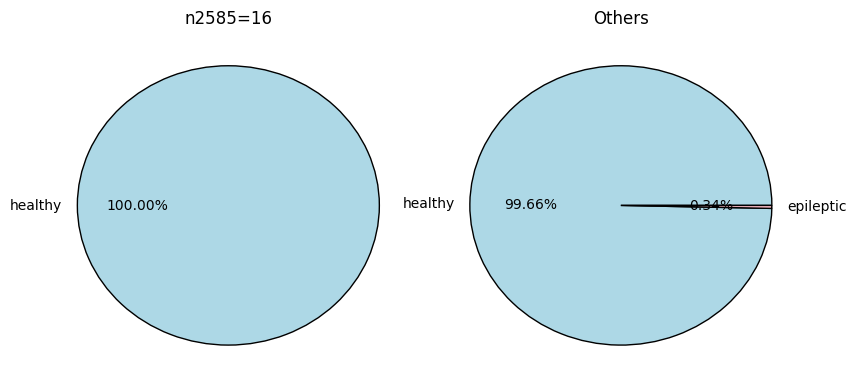

3.8748255061 n2365=3 3P Girls undr 21 hhld oldr thn NCDS chld


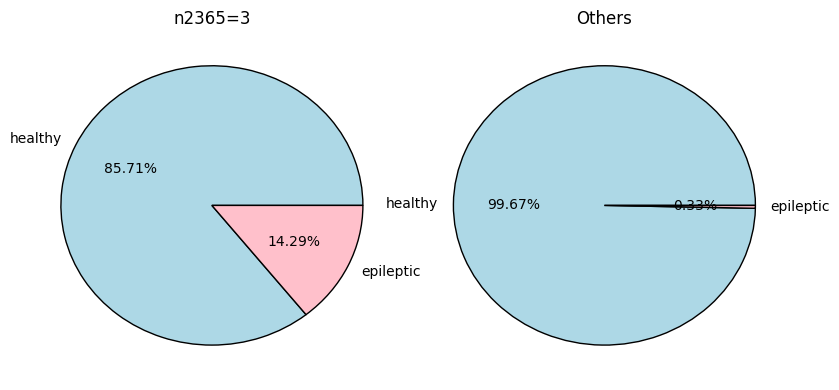

3.83016386288 n2599=12 3P Hospital admissions,general-MC 2:4


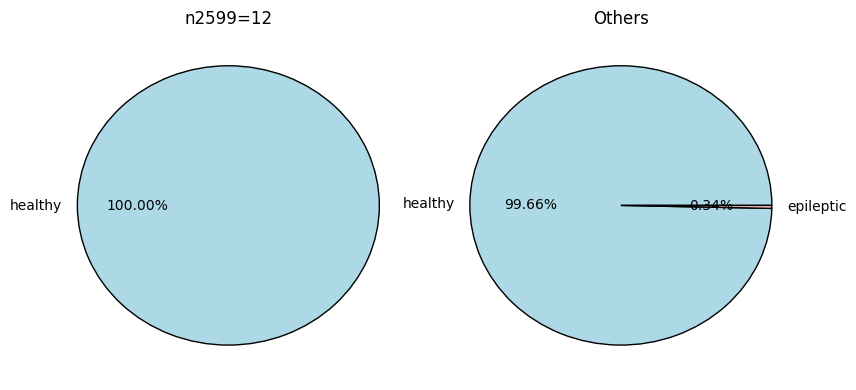

3.77146094996 n2476=39 3P Number of rooms in the accommodation


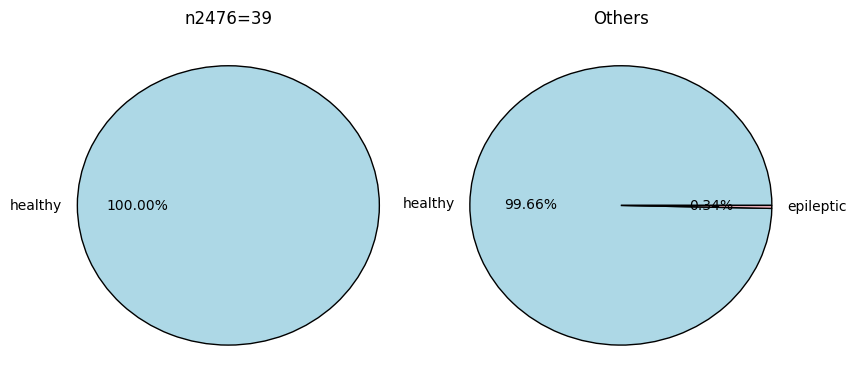

3.74914396956 n2230=47 3S 8th Subject studied


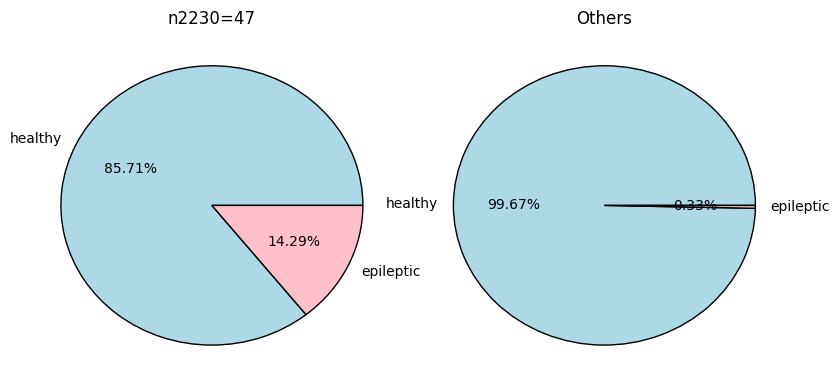

In [119]:
# get coefficient
best_model = gscv.best_estimator_
coef = best_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-21:][::-1]
most_neg_var_index = np.argsort(coef)[0:20]

print 'most positive variables'
for index in most_pos_var_index:
    print coef[index], x_df_extended.columns[index],
    
    # get variable name
    if '=' in x_df_extended.columns[index]:
        var_name = x_df_extended.columns[index].split('=', 1)[0]
    else:
        var_name = x_df_extended.columns[index]
    
    print var_df['label'].loc[var_name]

    var_name = x_df_extended.columns[index]

    mask_positive = (x_df_extended[var_name] == 1).values
    positive = y_df[mask_positive].value_counts().sort_index()
    negative = y_df[~mask_positive].value_counts().sort_index()

    fig, axs = plt.subplots(1, 2, figsize = (8,4))

    if positive.shape[0] == 2:
        labels = ['healthy', 'epileptic']
    else:
        labels = ['healthy']

    axs[0].pie(positive.values, labels = labels, autopct = '%.2f%%',\
            colors = ['lightblue', 'pink', 'gray'])
    axs[0].set_title(x_df_extended.columns[index])

    if negative.shape[0] == 2:
        labels = ['healthy', 'epileptic']
    else:
        labels = ['healthy']

    axs[1].pie(negative.values, labels = labels, autopct = '%.2f%%',\
            colors = ['lightblue', 'pink', 'gray'])
    axs[1].set_title('Others')

    fig.tight_layout()
    plt.savefig(x_df_extended.columns[index]+'.eps', format='eps', dpi=600)
    plt.show()

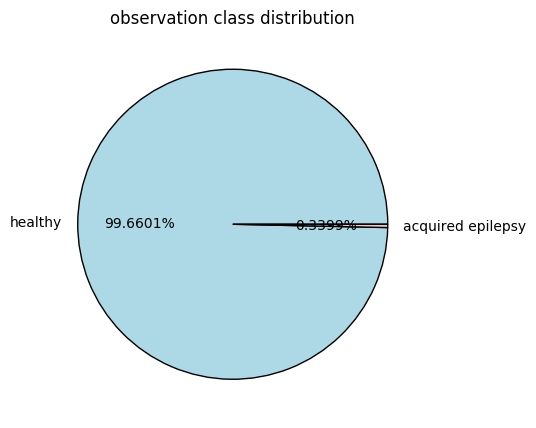

In [121]:
num_healthy = y_df.value_counts().iloc[0]
num_epil = y_df.value_counts().iloc[1]

plt.figure(figsize = (5,5))
plt.pie([num_healthy, num_epil], labels = ['healthy', 'acquired epilepsy'],\
       colors = ['lightblue', 'pink'], autopct = '%.4f%%')
plt.title('observation class distribution')
plt.savefig('obs_class_distr.eps', format='eps', dpi=600)
plt.show()